In [1]:
import pandas as pd
import numpy as np

import networkx as nx

import matplotlib.pyplot as plt

from compute_correlations import compute_pearson_correlation, compute_kendall_correlation
from graphs import build_full_graph, build_threshold_graph, find_max_clique, find_max_independent_set

def load_temp_by_season_interval(season, interval):
    cities = ["msk", "spb", "kaz", "ufa", "nn", "novosib", "vlad"]
    df = pd.DataFrame(columns=cities)
    for city in cities:
        df[city] = pd.read_csv(f"result_datasets/{city}_df_{season}_{interval}.csv")["T"]
    return df

def draw_pearson_graph(df, threshold=0.0):
    vertices = df.columns
    edge_weights = compute_pearson_correlation(df)
    g = build_threshold_graph(vertices, edge_weights, threshold)
    pos = nx.spring_layout(g)
    pos = nx.circular_layout(g)
    nx.draw(g, pos, with_labels=True, node_color='cornflowerblue')
    edge_labels = {k: round(v, 2) for (k, v) in nx.get_edge_attributes(g, 'weight').items()}
    nx.draw_networkx_edge_labels(g, pos, edge_labels);

def draw_kendall_graph(df, threshold=0.0):
    vertices = df.columns
    edge_weights = compute_kendall_correlation(df)
    g = build_threshold_graph(vertices, edge_weights, threshold)
    pos = nx.spring_layout(g)
    pos = nx.circular_layout(g)
    nx.draw(g, pos, with_labels=True, node_color='cornflowerblue')
    edge_labels = {k: round(v, 2) for (k, v) in nx.get_edge_attributes(g, 'weight').items()}
    nx.draw_networkx_edge_labels(g, pos, edge_labels);

def draw_graph_forall_seasons_by_interval(interval, corr_method, threshold=0.5):
    fig, axs = plt.subplots(2, 2, figsize=(7, 7))
    seasons = ['winter', 'spring', 'autumn', 'summer']
    dfs = [load_temp_by_season_interval(season, interval) for season in seasons]
    fig.suptitle(f"{corr_method} correlation graphs ({interval}, threshold={threshold})", fontsize=30)
    for i, df in enumerate(dfs):
        vertices = df.columns
        edge_weights = compute_pearson_correlation(df) if corr_method == 'pearson' else compute_kendall_correlation(df)
        g = build_threshold_graph(vertices, edge_weights, threshold)
        pos = nx.circular_layout(g)
        nx.draw(g, pos, ax=axs.flatten()[i], with_labels=True, node_color='lightblue', font_weight='bold')
        axs.flatten()[i].set_title(f"{seasons[i]}", fontsize=20, fontweight='bold')
        edge_labels = {k: round(v, 2) for (k, v) in nx.get_edge_attributes(g, 'weight').items()}
        nx.draw_networkx_edge_labels(g, pos, edge_labels, ax=axs.flatten()[i]);
    fig.tight_layout()
    
def draw_cliques_forall_seasons_by_interval(interval, corr_method, threshold=0.5):
    fig, axs = plt.subplots(2, 2, figsize=(7, 7))
    seasons = ['winter', 'spring', 'autumn', 'summer']
    dfs = [load_temp_by_season_interval(season, interval) for season in seasons]
    fig.suptitle(f"Max cliques for {corr_method} correlation graphs ({interval}, threshold={threshold})", fontsize=30)
    for i, df in enumerate(dfs):
        vertices = df.columns
        edge_weights = compute_pearson_correlation(df) if corr_method == 'pearson' else compute_kendall_correlation(df)
        threshold_graph = build_threshold_graph(vertices, edge_weights, threshold)
        clique = find_max_clique(threshold_graph)
        pos = nx.circular_layout(clique)
        nx.draw(clique, pos, ax=axs.flatten()[i], with_labels=True, node_color='lightblue', font_weight='bold')
        axs.flatten()[i].set_title(f"{seasons[i]}", fontsize=20, fontweight='bold')
        edge_labels = {k: round(v, 2) for (k, v) in nx.get_edge_attributes(clique, 'weight').items()}
        nx.draw_networkx_edge_labels(clique, pos, edge_labels, ax=axs.flatten()[i]);
    fig.tight_layout()
    
def draw_sets_forall_seasons_by_interval(interval, corr_method, threshold=0.5):
    fig, axs = plt.subplots(2, 2, figsize=(7, 7))
    seasons = ['winter', 'spring', 'autumn', 'summer']
    dfs = [load_temp_by_season_interval(season, interval) for season in seasons]
    fig.suptitle(f"Max ind. sets for {corr_method} correlation graphs ({interval}, threshold={threshold})", fontsize=30)
    for i, df in enumerate(dfs):
        vertices = df.columns
        edge_weights = compute_pearson_correlation(df) if corr_method == 'pearson' else compute_kendall_correlation(df)
        threshold_graph = build_threshold_graph(vertices, edge_weights, threshold)
        iset = find_max_independent_set(threshold_graph)
        pos = nx.circular_layout(iset)
        nx.draw(iset, pos, ax=axs.flatten()[i], with_labels=True, node_color='lightblue', font_weight='bold')
        axs.flatten()[i].set_title(f"{seasons[i]}", fontsize=20, fontweight='bold')
    fig.tight_layout()


/Users/m/dev/python/random-variable-networks/compute_correlations.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  edge_weights[(col1, col2)] = correlation_matrix[col1][j]
/Users/m/dev/python/random-variable-networks/compute_correlations.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  edge_weights[(col1, col2)] = correlation_matrix[col1][j]
/Users/m/dev/python/random-variable-networks/compute_correlations.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by

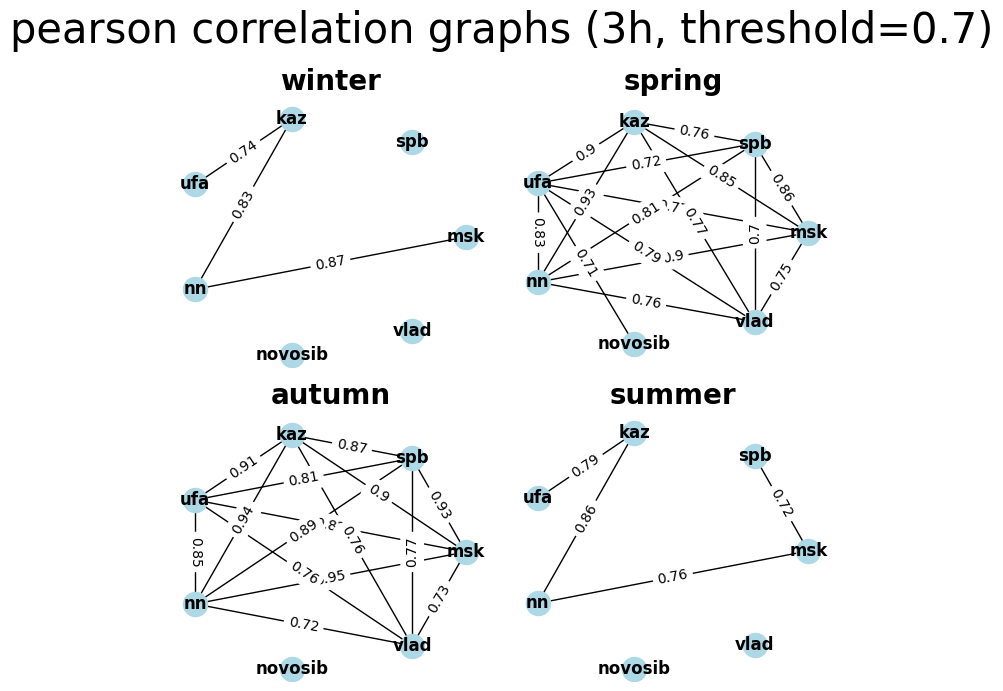

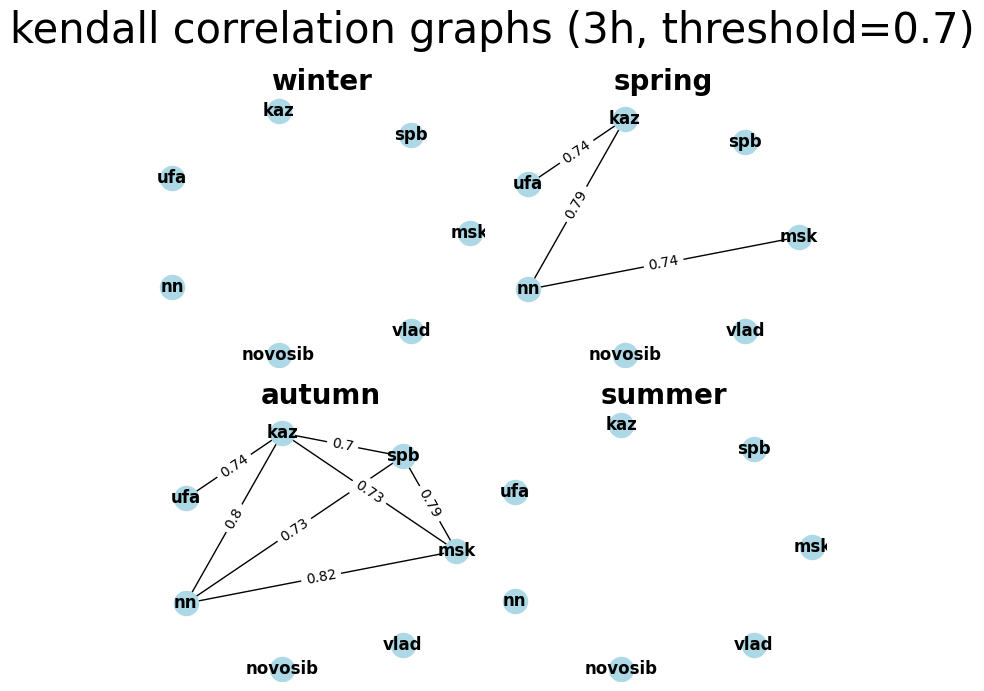

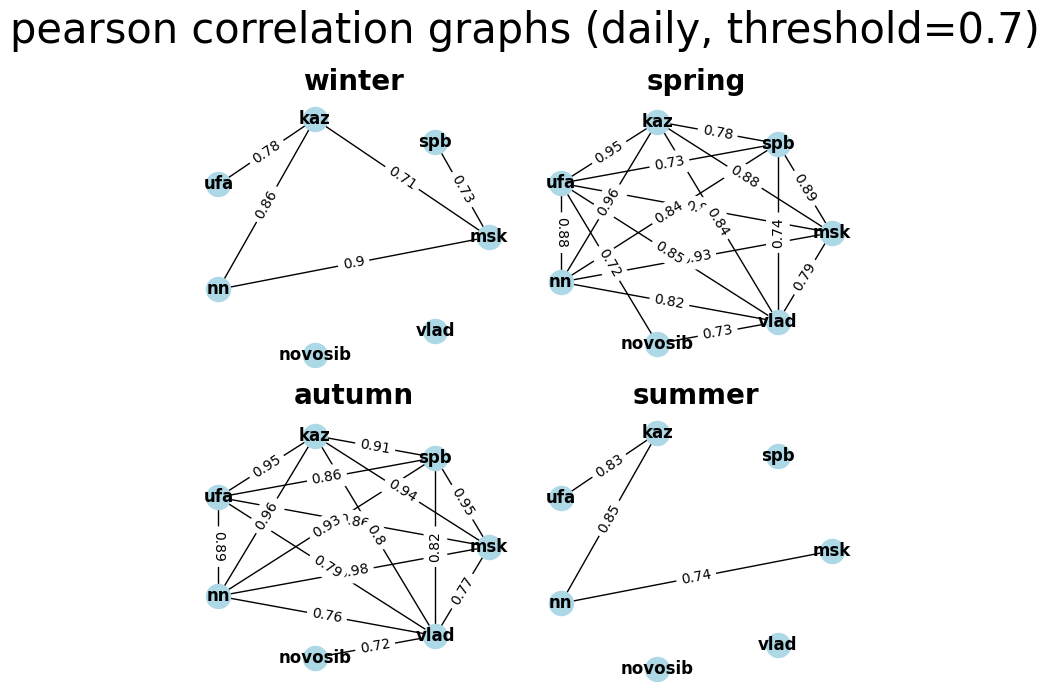

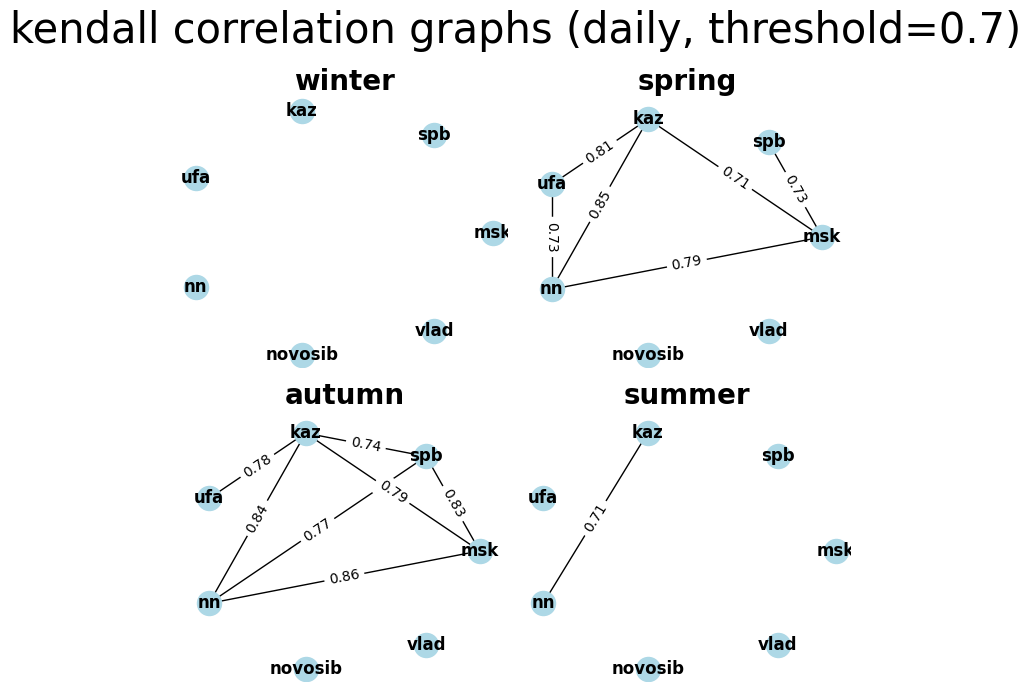

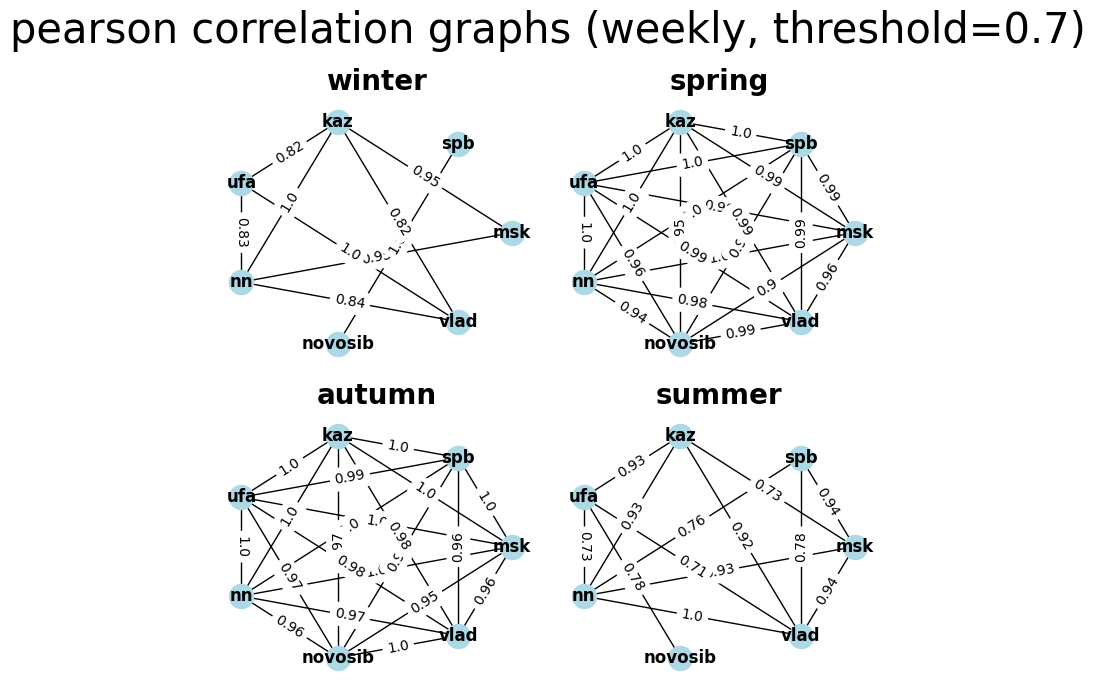

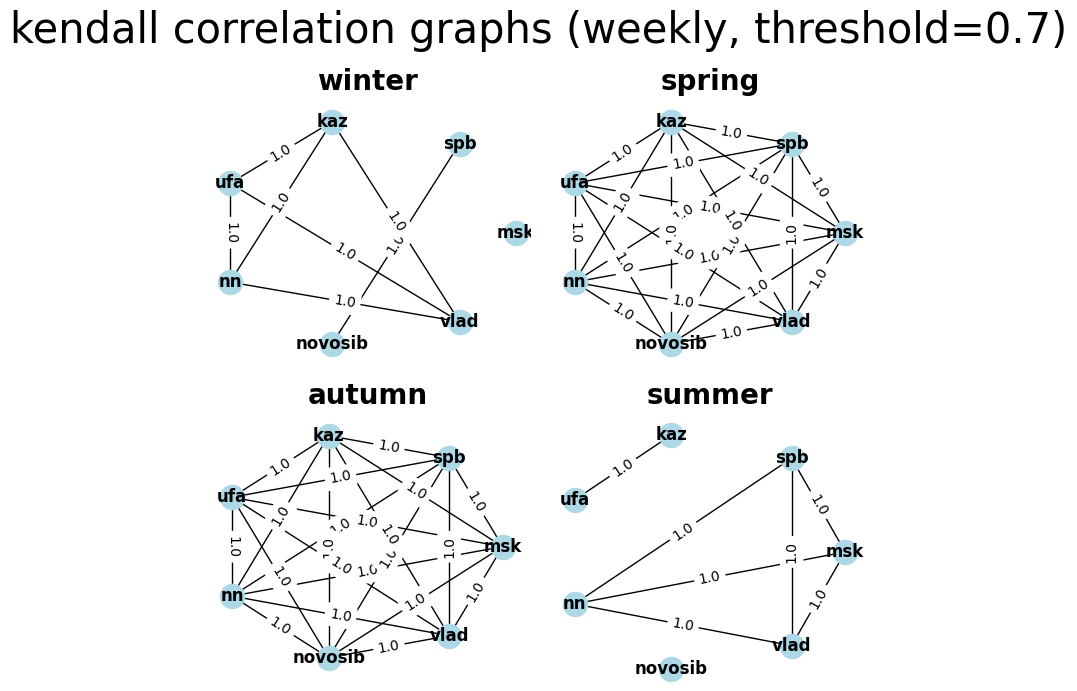

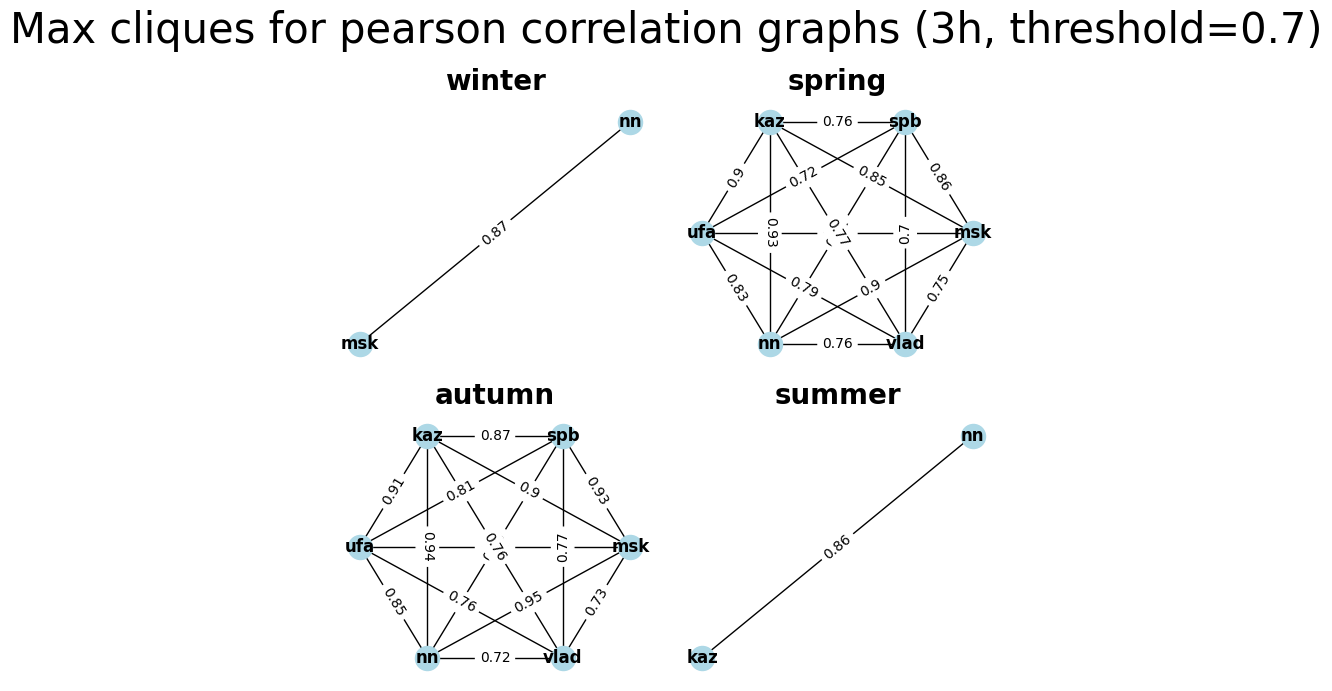

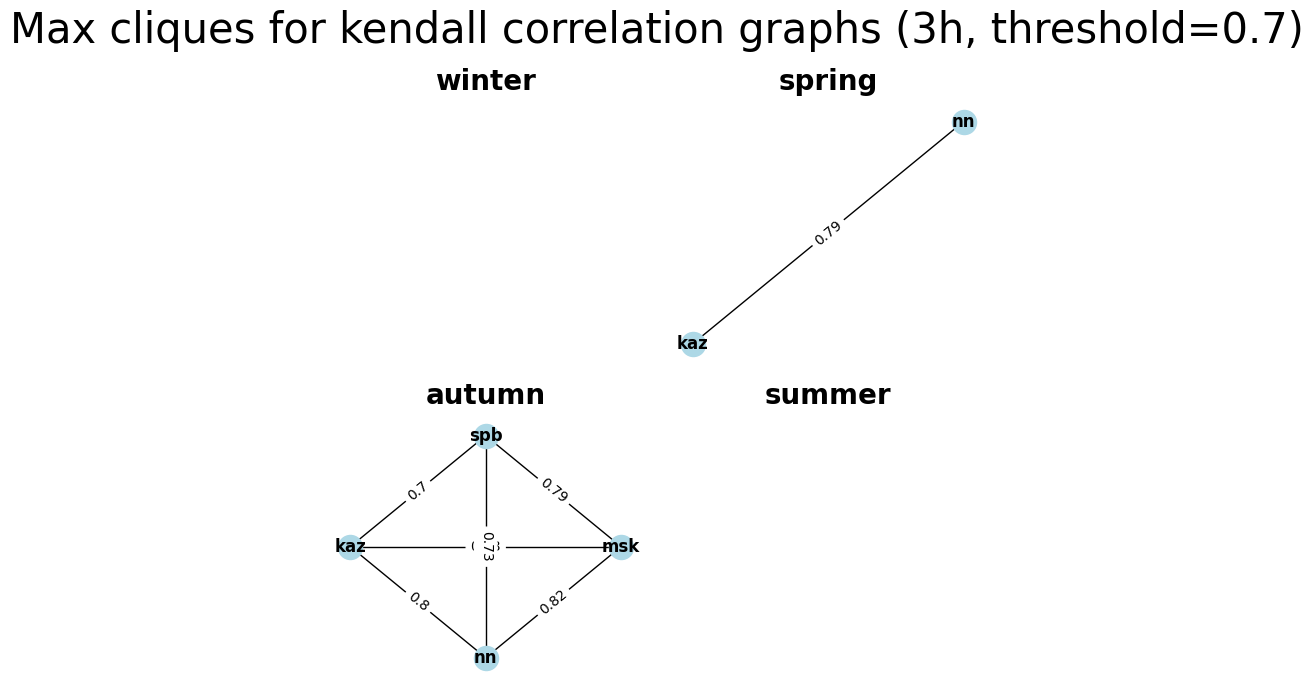

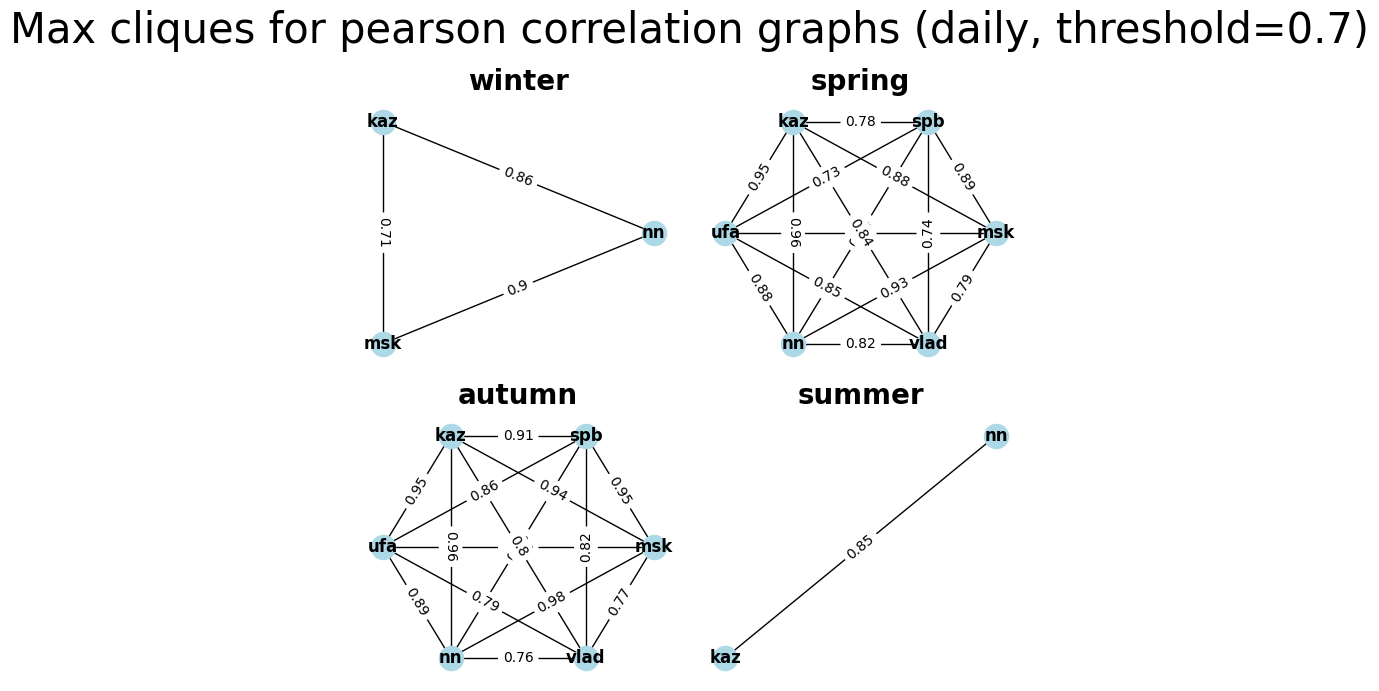

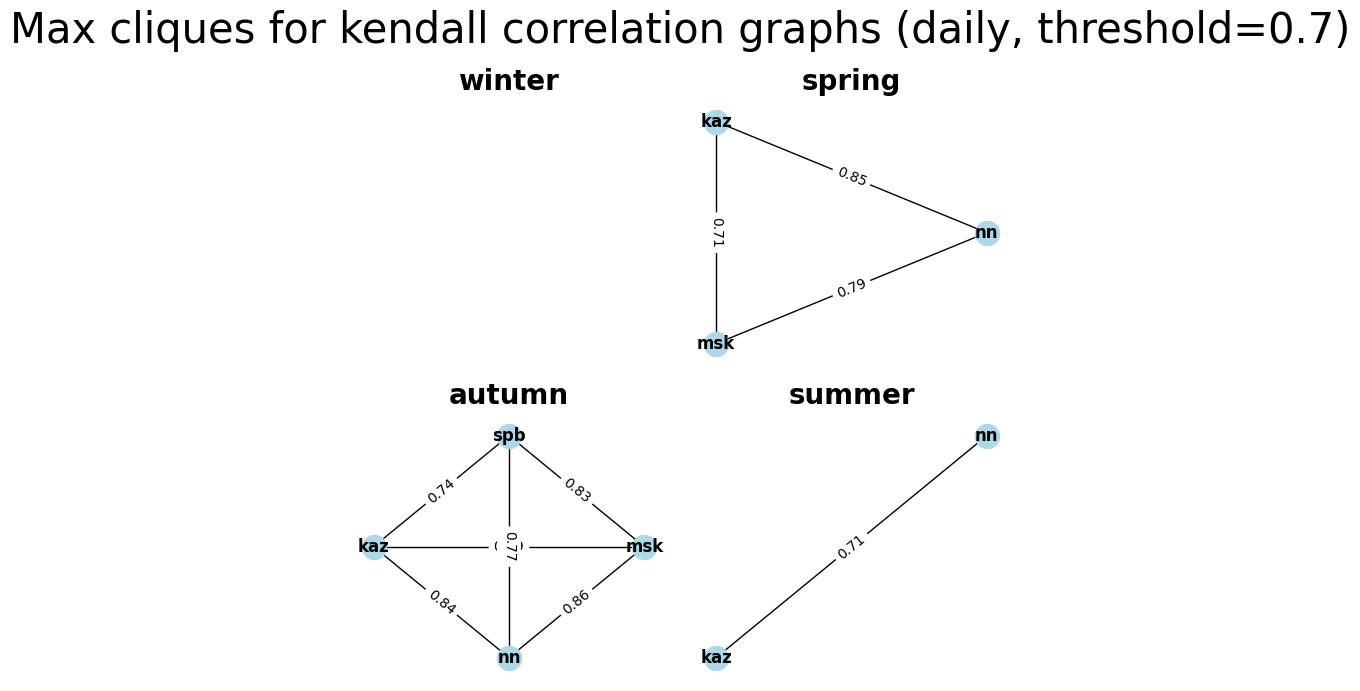

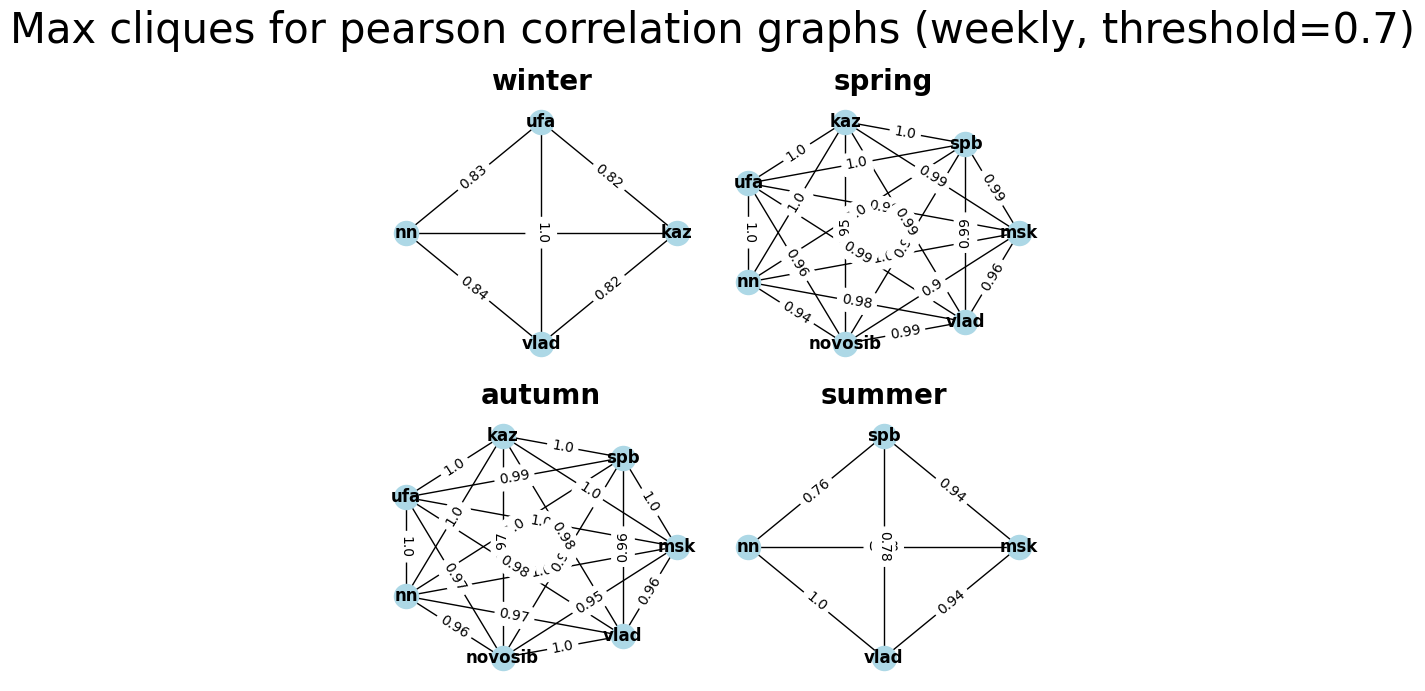

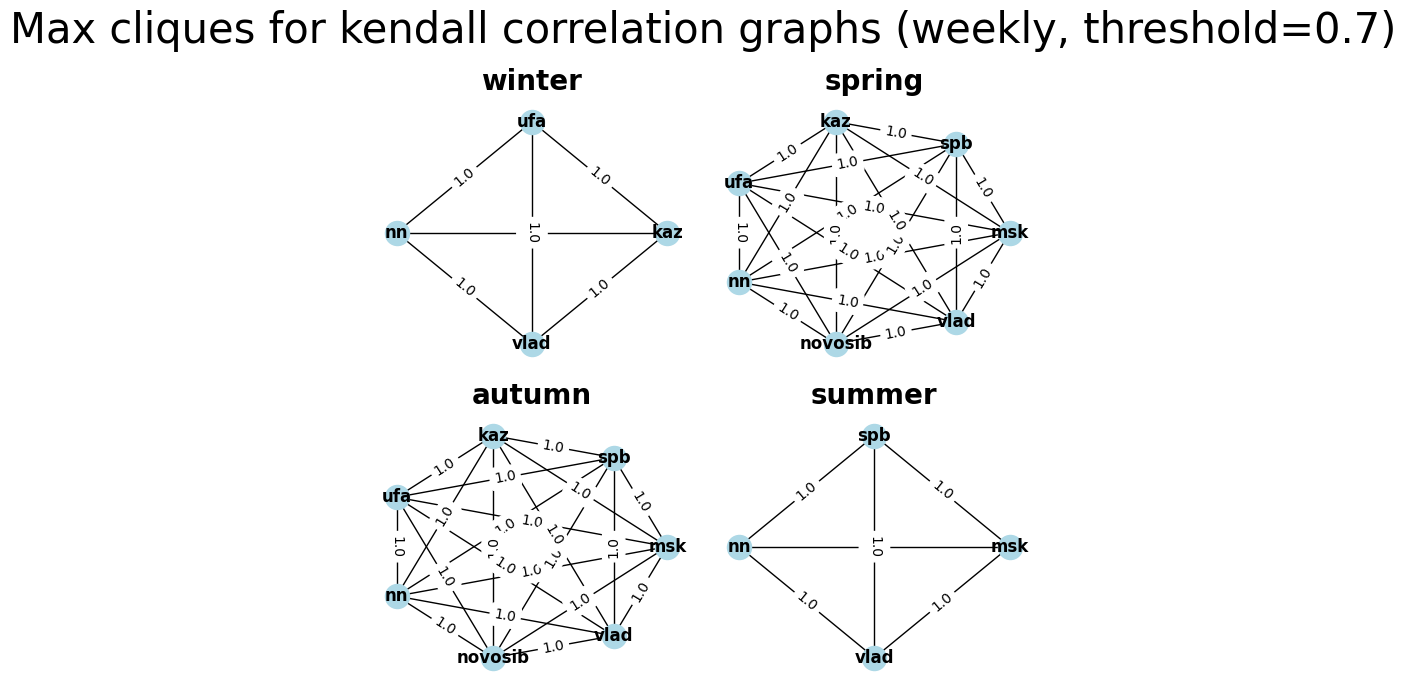

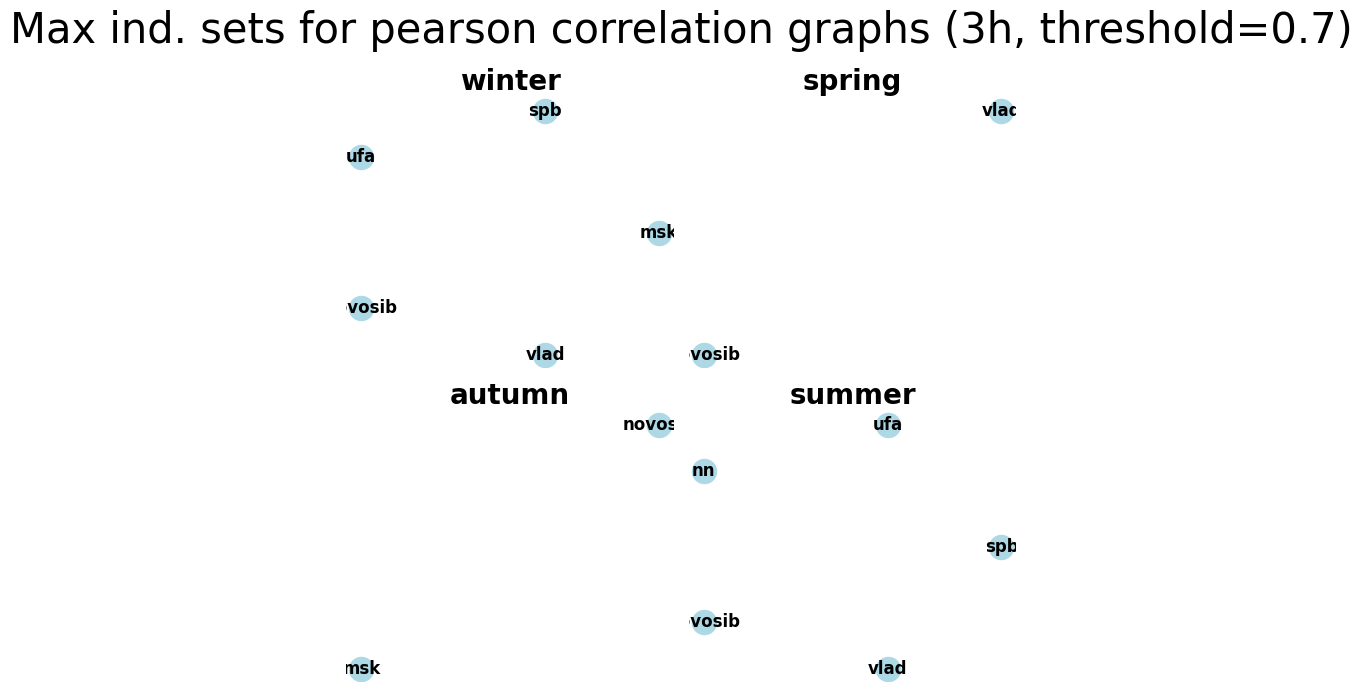

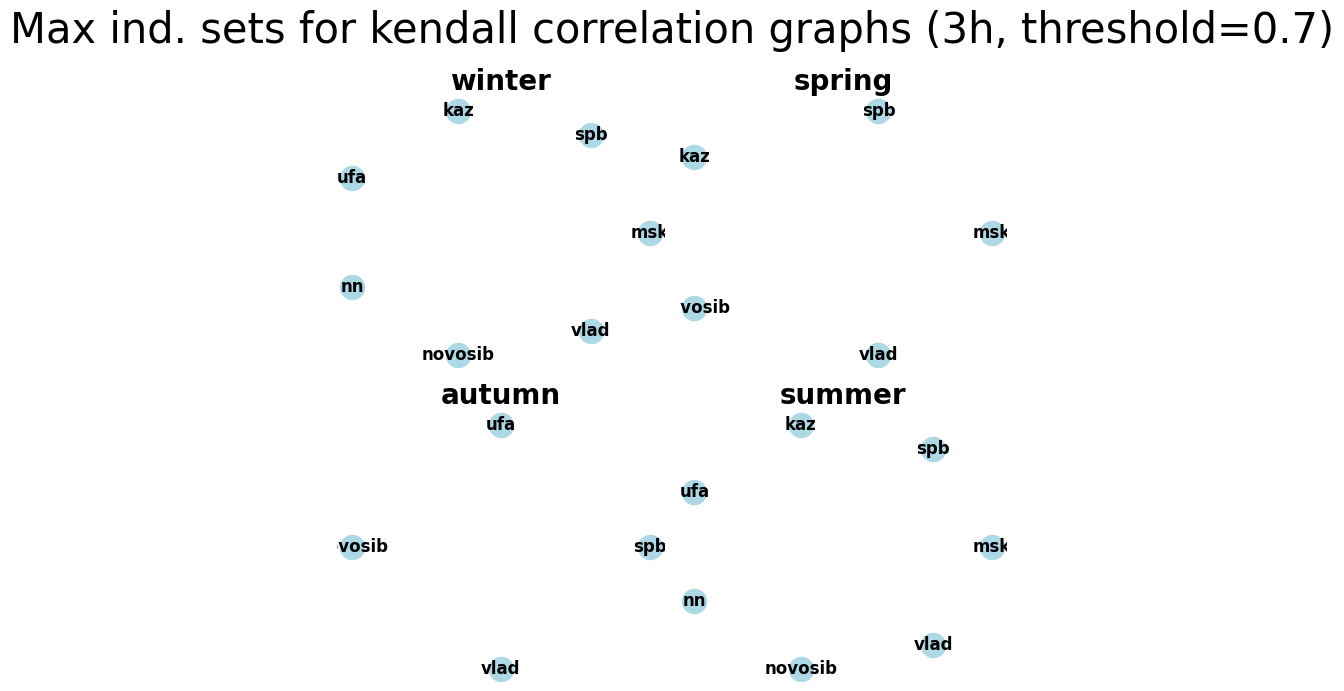

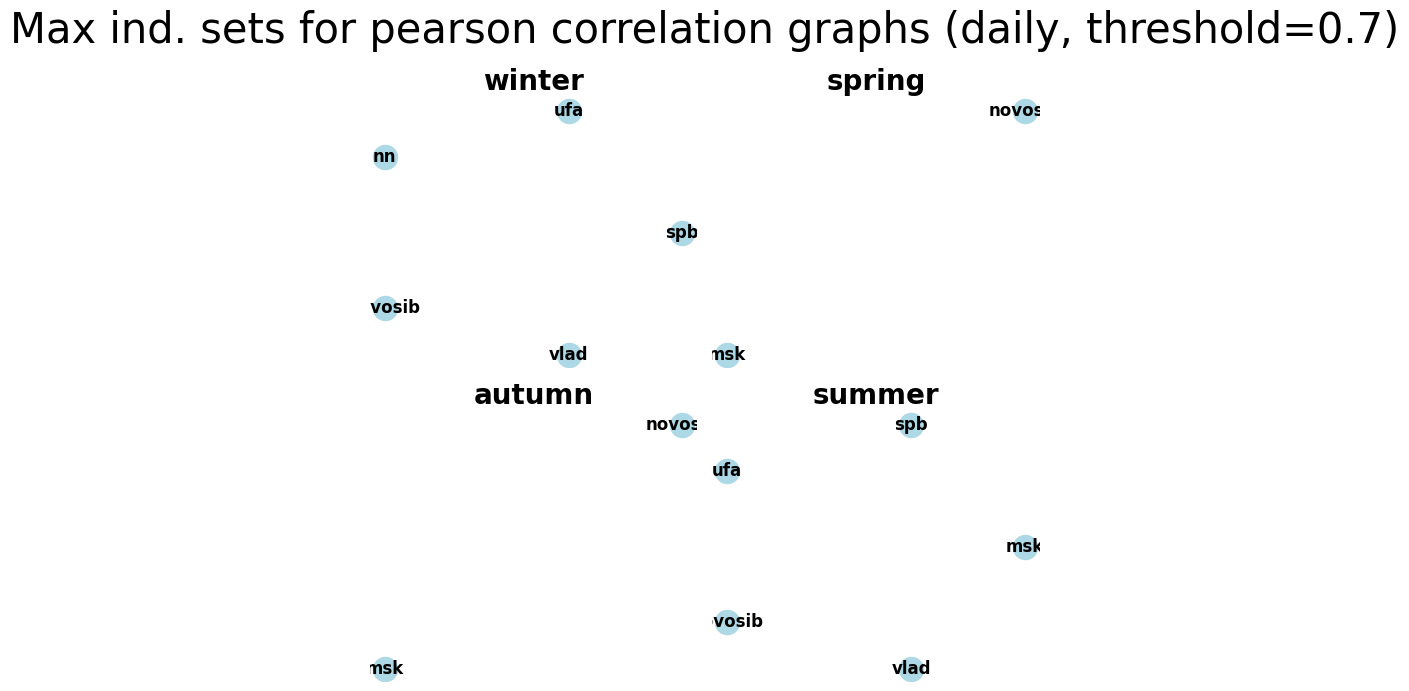

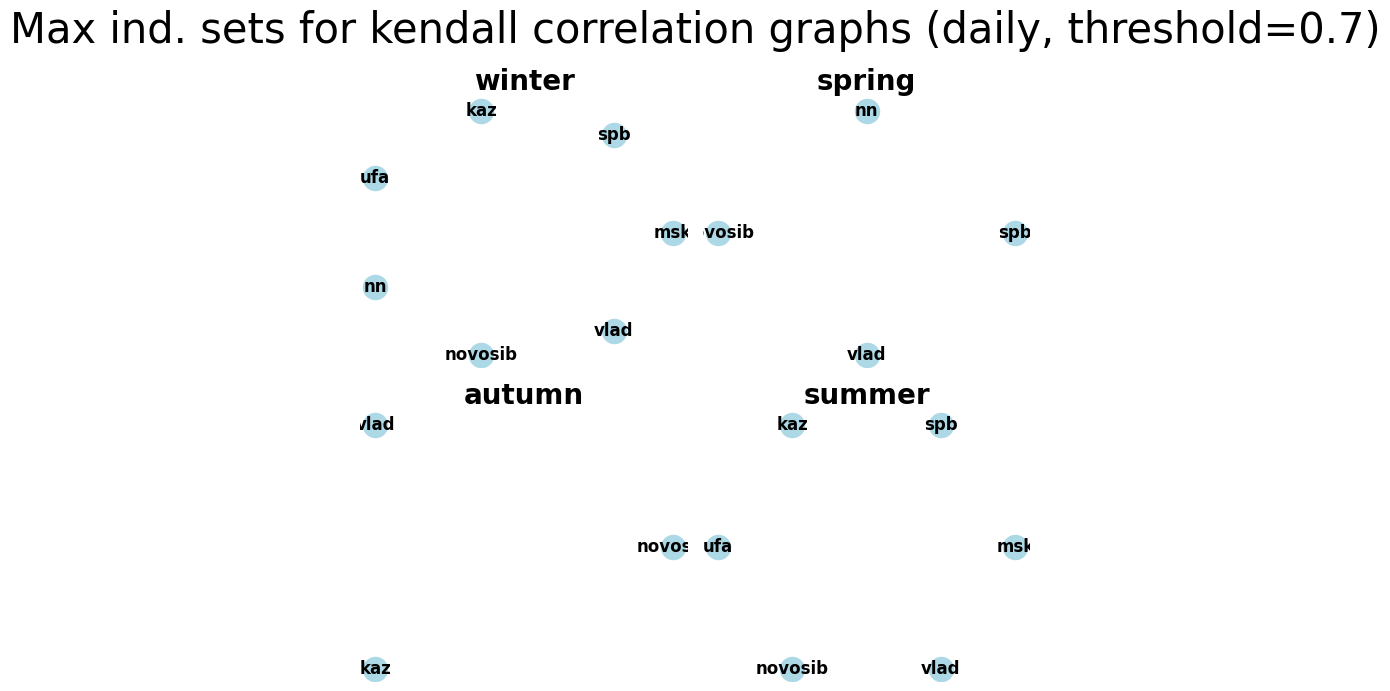

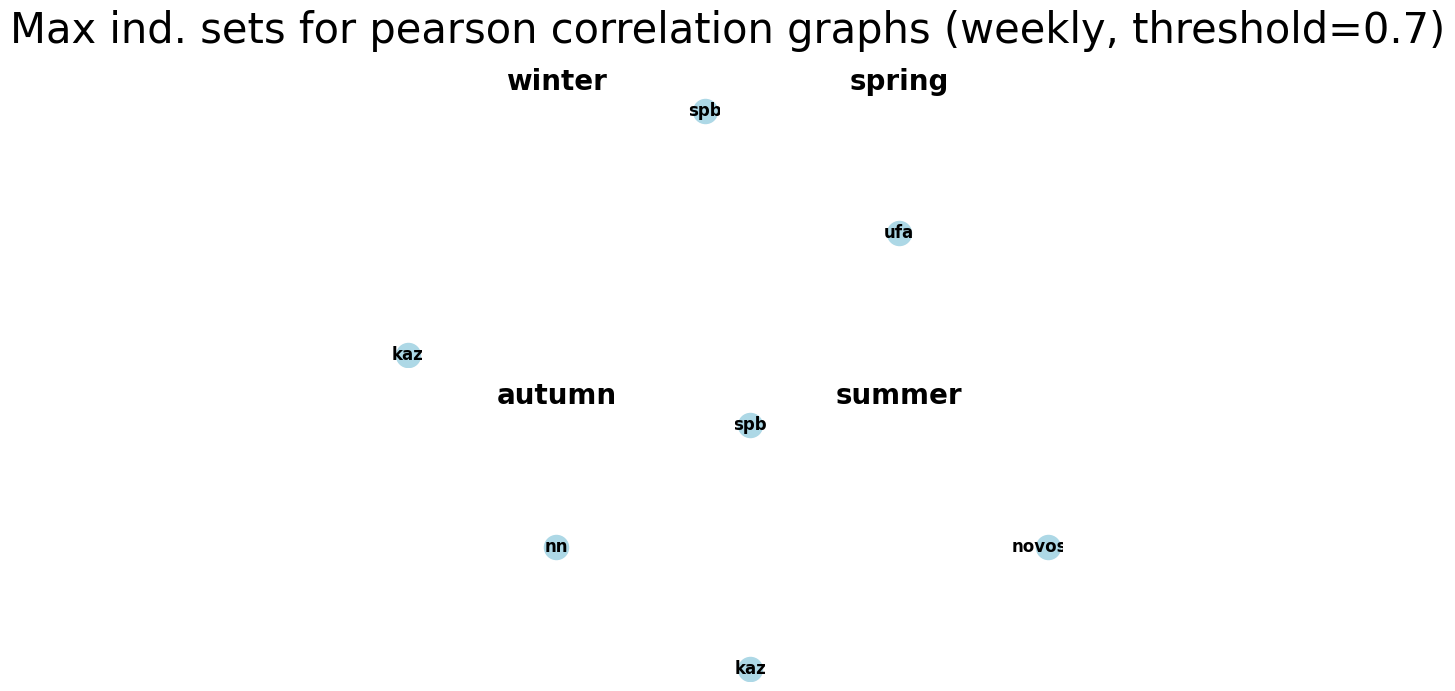

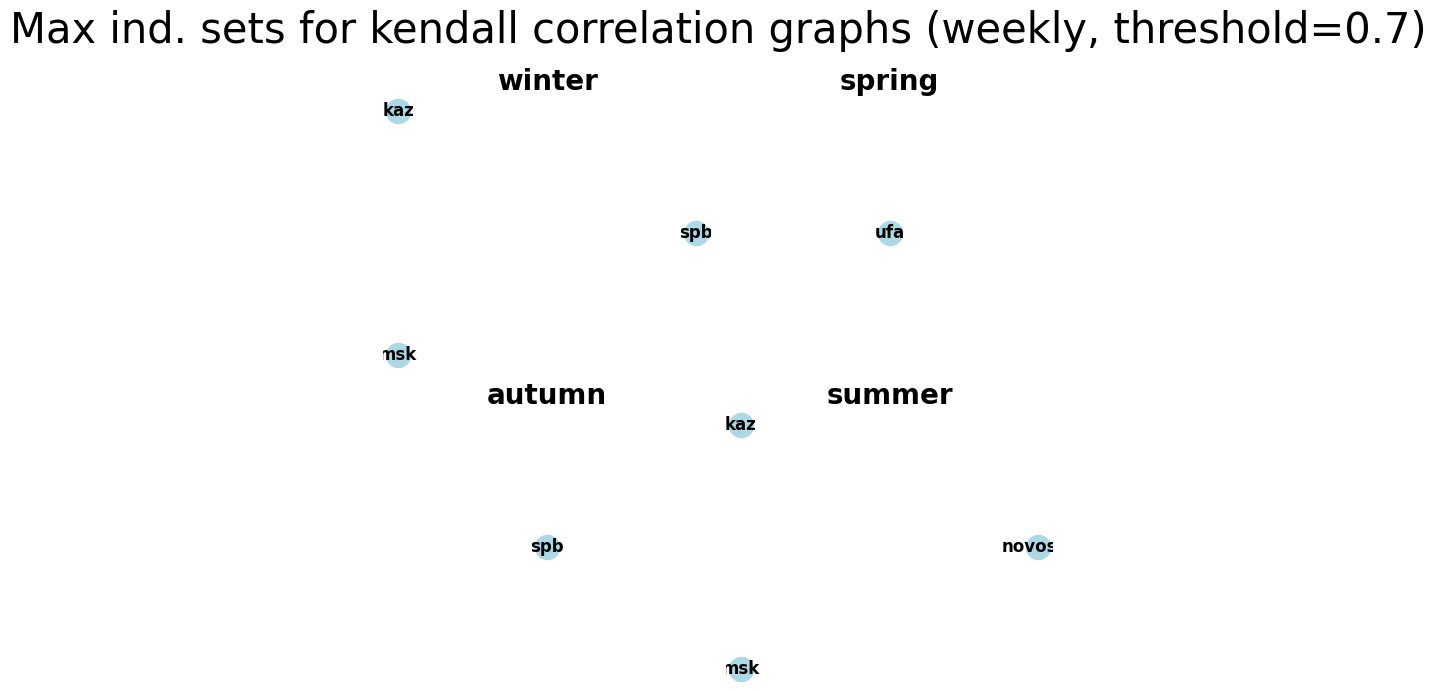

In [2]:
intervals = ["3h", "daily", "weekly"]
methods = ["pearson", "kendall"]
threshold = 0.5

for interval in intervals:
    for corr_method in methods:
        draw_graph_forall_seasons_by_interval(interval, corr_method, threshold)

for interval in intervals:
    for corr_method in ["pearson", "kendall"]:
        draw_cliques_forall_seasons_by_interval(interval, corr_method, threshold)


for interval in intervals:
    for corr_method in methods:
        draw_sets_forall_seasons_by_interval(interval, corr_method, threshold)

/Users/m/dev/python/random-variable-networks/compute_correlations.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  edge_weights[(col1, col2)] = correlation_matrix[col1][j]
/Users/m/dev/python/random-variable-networks/compute_correlations.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  edge_weights[(col1, col2)] = correlation_matrix[col1][j]
/Users/m/dev/python/random-variable-networks/compute_correlations.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by 

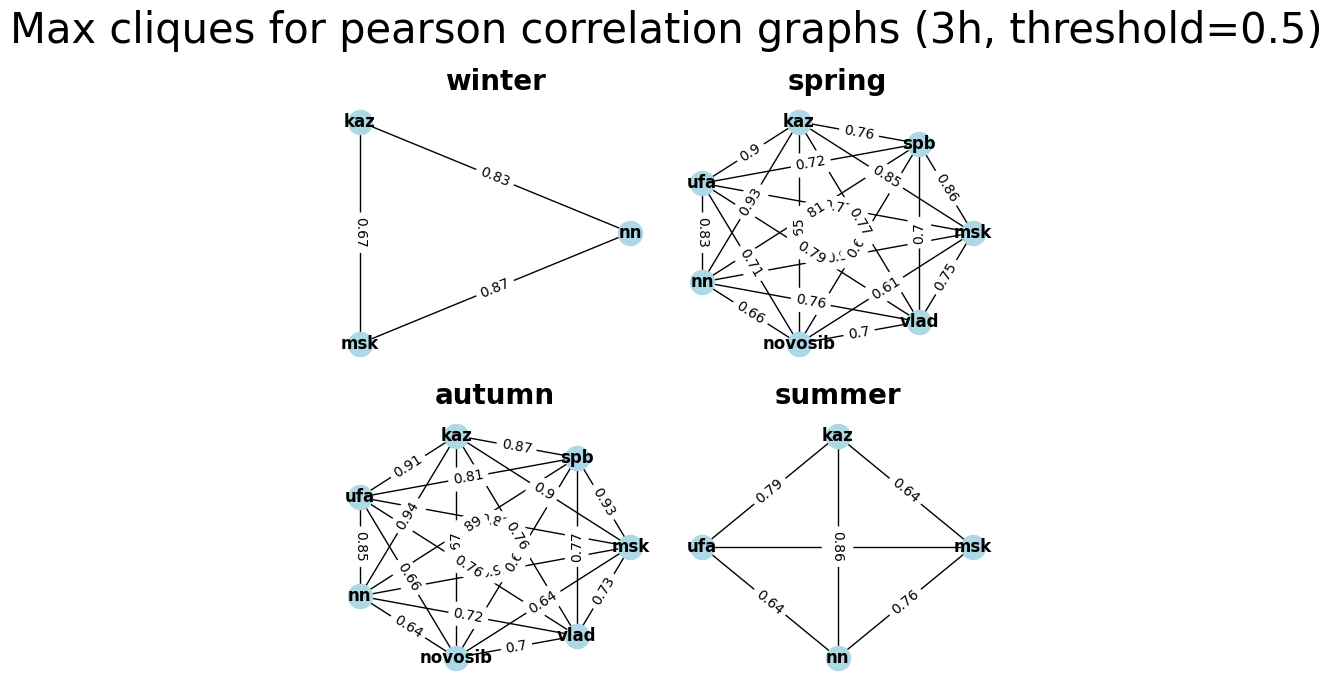

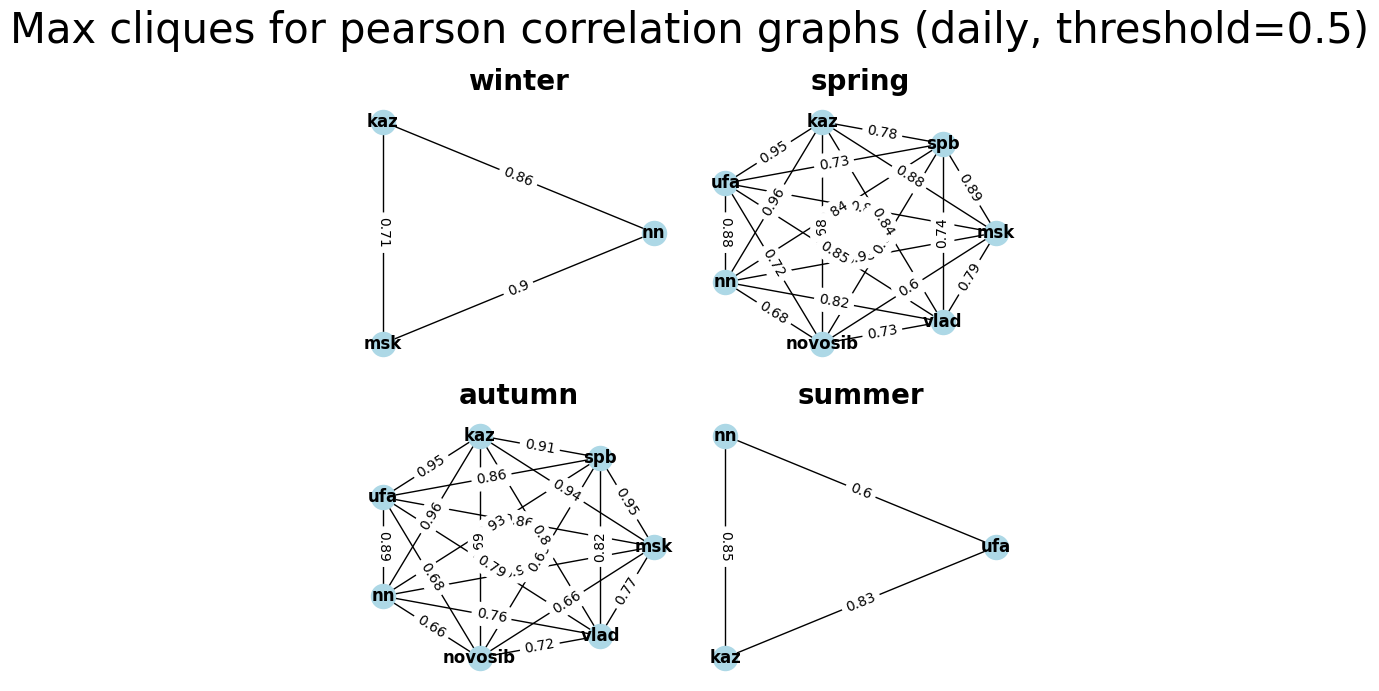

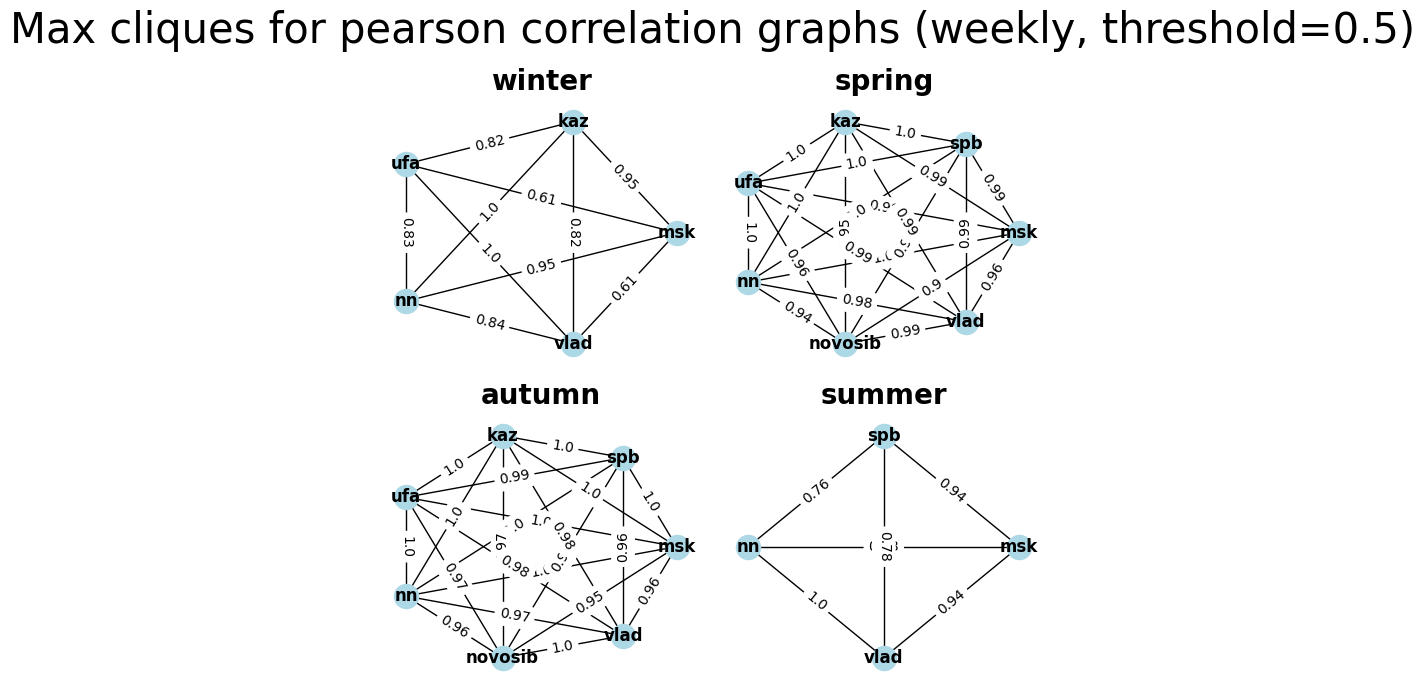

In [3]:
for interval in ["3h", "daily", "weekly"]:
    for corr_method in ["pearson"]:
        draw_cliques_forall_seasons_by_interval(interval, corr_method, 0.5)



In [4]:

df = pd.DataFrame({
    'moscow': [28.0, 23.0, 28.0, 22.0, 22.0, 16.0, 25.0, 24.0, 20.0, 18.0],
    'spb': [10.0, 21.0, 21.0, 17.0, 21.0, 11.0, 22.0, 10.0, 13.0, 21.0],
    'kazan': [21.0, 23.0, 23.0, 20.0, 23.0, 26.0, 32.0, 22.0, 22.0, 24.0],
    'ufa': [16.0, 11.0, 19.0, 14.0, 18.0, 19.0, 17.0, 11.0, 17.0, 11.0],
    'nizhny': [20.0, 20.0, 15.0, 19.0, 16.0, 22.0, 15.0, 17.0, 18.0, 18.0],
})


df.corr(method='pearson')
vertices = ['moscow', 'spb', 'kazan', 'ufa', 'nizhny']
edge_weights = compute_pearson_correlation(df)

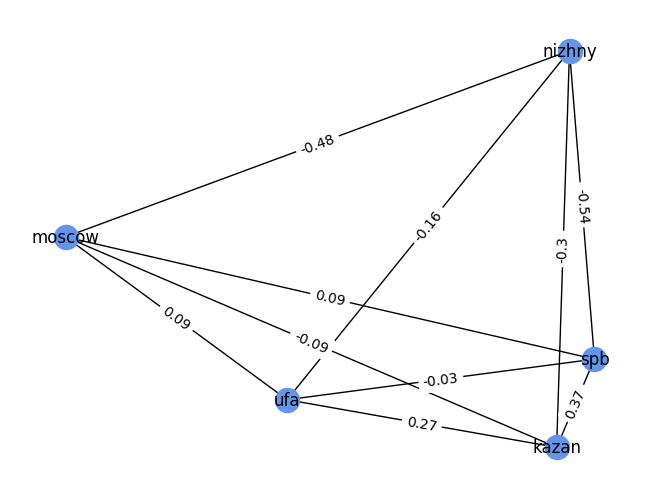

In [5]:
g_full = build_full_graph(vertices, edge_weights)
pos = nx.spring_layout(g_full)
nx.draw(g_full, pos, with_labels=True, node_color='cornflowerblue')
edge_labels = {k: round(v, 2) for (k, v) in nx.get_edge_attributes(g_full, 'weight').items()}
nx.draw_networkx_edge_labels(g_full, pos, edge_labels);

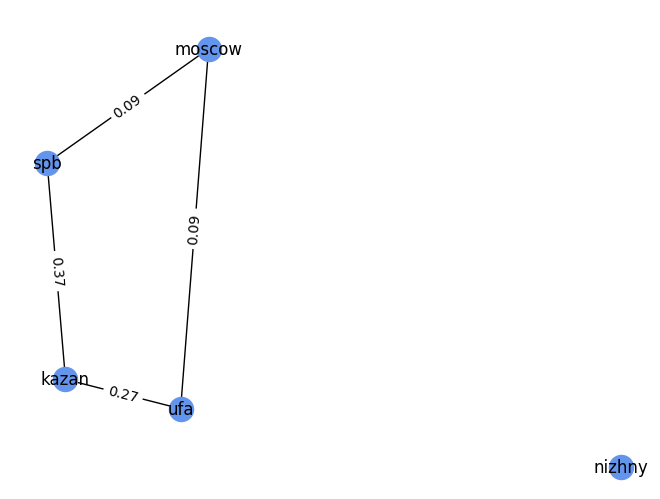

In [6]:
g = build_threshold_graph(vertices, edge_weights, threshold=0.0)
pos = nx.spring_layout(g)
nx.draw(g, pos, with_labels=True, node_color='cornflowerblue')
edge_labels = {k: round(v, 2) for (k, v) in nx.get_edge_attributes(g, 'weight').items()}
nx.draw_networkx_edge_labels(g, pos, edge_labels);

In [7]:
find_max_clique(g)

In [8]:
find_max_independent_set(g)